# PCA on days

*Last edit 8/15*

This notebook shows how I used PCA to better understand what kinds of days there are, in terms of their crowdedness patterns.

TODO: Refactor into functions without harming the story of the analysis. Add more English description to make the story clear.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from pandas.tseries.holiday import USFederalHolidayCalendar

In [2]:
import sys
sys.path.append('../src/')
import aposch_functions as aposch

#### Get df04_train dataset

In [3]:
# read in data
data2019 = pd.read_csv('../data/2019_RAW_APC_Data.csv.gz')

# get df04
df04 = aposch.clean_data(data2019)

# split into test/train sets
df04_train, df04_test = train_test_split(df04,
                                         test_size=0.2,
                                         random_state=19)

## Create dataset for PCA

In [4]:
# Group passwithin by Hour, DOY, and station (stadir_ID). Take the mean.
pw_agg = df04_train.groupby(['Hour','DOY','stadir_ID'])['passwithin'].mean()

In [5]:
day_view = pw_agg.reset_index().pivot(index='DOY', columns=['Hour','stadir_ID'])

In [6]:
day_view.isna().sum().sum()

47628

In [7]:
day_view.shape[0] * day_view.shape[1]

280320

About 15% of entries in this matrix are NaN.

In [8]:
# Try filling NaNs with 0
day_view_fill0 = day_view.fillna(0)

## Run PCA algorithm

In [9]:
pca02 = PCA(n_components=0.7, svd_solver='full')

day_pc = pca02.fit_transform(day_view_fill0)

C:\Users\augus\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


In [10]:
#station_pc
pca02.explained_variance_ratio_

array([0.32673617, 0.09220658, 0.05595519, 0.03488235, 0.02621848,
       0.01991014, 0.01727938, 0.01461438, 0.01431709, 0.01355396,
       0.0116944 , 0.01084389, 0.01049458, 0.00953156, 0.00887304,
       0.00873738, 0.00811739, 0.00752609, 0.00741083, 0.00687921])

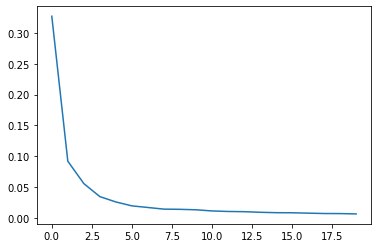

In [11]:
plt.plot(pca02.explained_variance_ratio_)

33% of variance expliained by first PC, then 9% by second PC, then 6%, then 3%. then 3%, 2%, 2%...

I think this is either essentially 3-dimensional, or essentially 2-dimensional.

Look at pairplot to determine how many components we need:

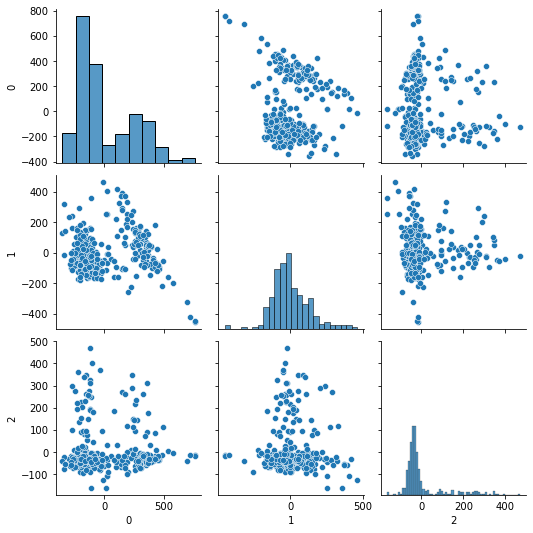

In [12]:
sns.pairplot(pd.DataFrame(day_pc[:,[0,1,2]]))

It looks like the first two PCs reveal clusters.

Next steps: choose a clustering method that captures the two by-eye-visible clusters; then figure out what aspect of each point makes it belong to a particular cluster versus the other.

## Clustering for Day PCA

Choose a clustering method that captures the two by-eye-visible clusters; then figure out what aspect of each point makes it belong to a particular cluster versus the other.

- TODO: Fix colors, they look awful right now

Plot the data we'll be using for clustering:

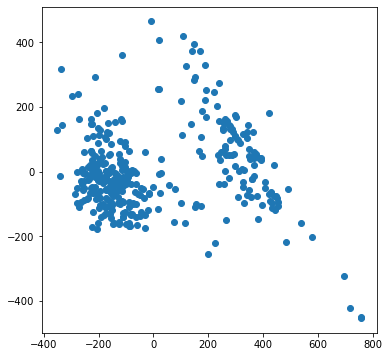

In [13]:
plt.figure(figsize=(6,6))
plt.scatter(day_pc[:,0], day_pc[:,1])

Try K-means:

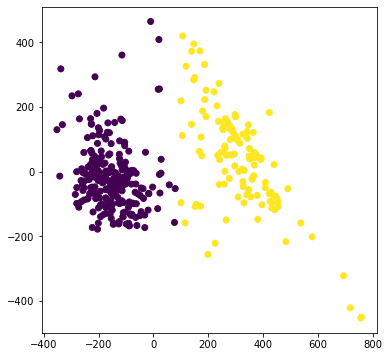

In [14]:
kmeans = KMeans(n_clusters = 2)

labels = kmeans.fit_predict(day_pc[:,[0,1]])

plt.figure(figsize=(6,6))
plt.scatter(day_pc[:,0], day_pc[:,1], c=labels)

Try DBSCAN:

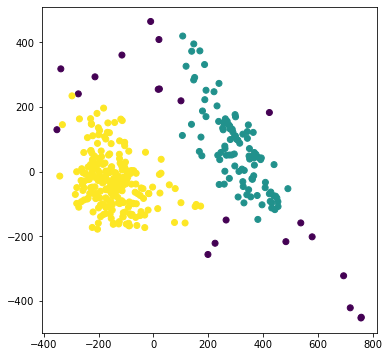

In [15]:
std = np.std(day_pc[:,[0,1]])

dbscan = DBSCAN(eps = std * 0.4) # 0.4 std was the best I could find
# DBSCAN is really not the best for this problem

labels = dbscan.fit_predict(day_pc[:,[0,1]])

plt.figure(figsize=(6,6))
plt.scatter(day_pc[:,0], day_pc[:,1], c=labels)

Try Gaussian Mixture:

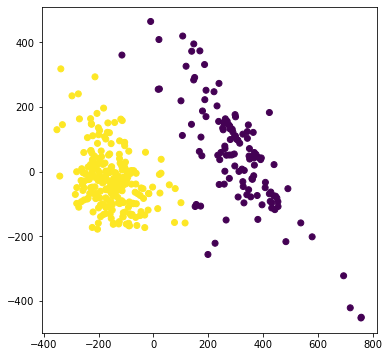

In [16]:
gmm = GaussianMixture(n_components=2, covariance_type='full')

labels = gmm.fit_predict(day_pc[:,[0,1]])

plt.figure(figsize=(6,6))
plt.scatter(day_pc[:,0], day_pc[:,1], c=labels)

The Gaussian Mixture looks the best.

## Investigate the clusters

Make a dataframe to investigate this.

In [17]:
dates2019 = pd.date_range("2019-01-01", periods=365, freq="D")

In [18]:
# day_pc_investigation

day_pci = pd.DataFrame(data=day_pc[:,[0,1]], index=dates2019, columns=['PC1','PC2'])

cal = USFederalHolidayCalendar()

day_pci['Holiday'] = day_pci.index.isin(cal.holidays())

day_pci['DayName'] = day_pci.index.day_name()

day_pci['GMM_Label'] = labels

day_pci

,PC1,PC2,Holiday,DayName,GMM_Label
2019-01-01,490.275316,-53.000003,True,Tuesday,0
2019-01-02,-2.964969,-48.123159,False,Wednesday,1
2019-01-03,23.803727,-66.486044,False,Thursday,1
2019-01-04,28.246600,37.848837,False,Friday,1
2019-01-05,365.668706,-13.013612,False,Saturday,0
...,...,...,...,...,...
2019-12-27,167.387871,62.048721,False,Friday,0
2019-12-28,374.024977,52.856909,False,Saturday,0
2019-12-29,326.077150,115.561285,False,Sunday,0
2019-12-30,115.423423,-159.015621,False,Monday,1


Plot in seaborn, coloring by holidays:

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

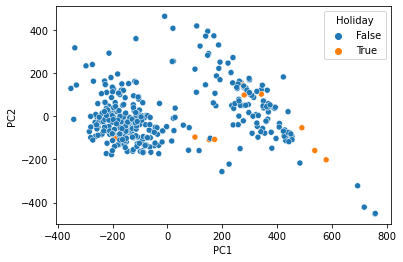

In [19]:
sns.scatterplot(data=day_pci, x='PC1', y='PC2', hue='Holiday')

Holidays mostly appear in the right cluster or on the boundary.

Plot in seaborn, with both day of week and holiday information:

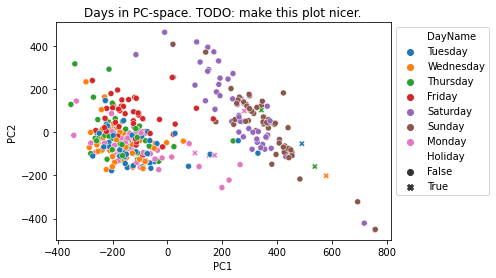

In [21]:
ax = sns.scatterplot(data=day_pci, x='PC1', y='PC2', hue='DayName', style='Holiday')
ax.set_title('Days in PC-space. TODO: make this plot nicer.')
sns.move_legend(ax, "upper left", bbox_to_anchor = (1,1))
plt.savefig('../images/PCA_days.png', bbox_inches='tight')

Aha!

We immediately see a Saturday-Sunday-holiday-dominated cluster on the right, and a weekday-dominated cluster on the left.

Below I investigate the weekdays of the right-hand cluster:

In [22]:
df = day_pci

df[(df['DayName'].isin(['Friday','Monday'])) & (~df['GMM_Label'])].sort_values('DayName')

,PC1,PC2,Holiday,DayName,GMM_Label
2019-07-05,105.547543,111.471194,False,Friday,0
2019-11-29,17.466008,254.112355,False,Friday,0
2019-12-27,167.387871,62.048721,False,Friday,0
2019-01-21,152.113627,-108.153178,True,Monday,0
2019-02-04,264.970150,-149.868202,False,Monday,0
2019-02-11,224.755691,-221.674062,False,Monday,0
2019-02-18,172.099591,-106.888979,True,Monday,0
2019-05-27,275.188895,144.048209,True,Monday,0
2019-09-02,280.278696,98.911586,True,Monday,0
2019-10-21,198.732674,-256.370525,False,Monday,0


Aha! These cluster-0 Fridays are all holiday-like days - July 5th, Black Friday, and Christmas week Friday.

Monday non-holidays are a bit harder to understand. Feb 4 and Feb 11 were snowstorms.

Did some research on Oct 21 and didn't conclude anything. That point was right on the line between the two clusters anyway. Maybe there were enough small things going on to encourage people to take a day off work - day after an NFL game, a film festival, etc.

Check that there are no Sat-Sun days in cluster 1:

In [23]:
df = day_pci

df[(df['DayName'].isin(['Saturday','Sunday'])) & (~df['GMM_Label'])].sort_values('DayName')

,PC1,PC2,Holiday,DayName,GMM_Label
2019-01-05,365.668706,-13.013612,False,Saturday,0
2019-04-27,282.412355,130.980811,False,Saturday,0
2019-10-26,717.648944,-421.278815,False,Saturday,0
2019-05-11,234.652593,50.320063,False,Saturday,0
2019-05-18,150.322200,290.727942,False,Saturday,0
...,...,...,...,...,...
2019-05-19,241.848202,36.746006,False,Sunday,0
2019-05-12,360.872002,-24.139998,False,Sunday,0
2019-05-05,368.119173,19.841893,False,Sunday,0
2019-06-16,314.660221,87.505801,False,Sunday,0


Yep, that's every Saturday and Sunday.

Investigate Tues-Weds-Thurs days in cluster 0:

In [24]:
df = day_pci

df[(df['DayName'].isin(['Tuesday','Wednesday','Thursday'])) & (~df['GMM_Label'])].sort_values('DayName')

,PC1,PC2,Holiday,DayName,GMM_Label
2019-07-04,342.600545,102.644055,True,Thursday,0
2019-11-28,537.283006,-158.818569,True,Thursday,0
2019-12-26,239.744983,-40.055258,False,Thursday,0
2019-01-01,490.275316,-53.000003,True,Tuesday,0
2019-02-12,156.141939,-101.841182,False,Tuesday,0
2019-12-24,330.067116,-96.953177,False,Tuesday,0
2019-12-31,258.133809,-38.985578,False,Tuesday,0
2019-12-25,578.709685,-201.833830,True,Wednesday,0


Feb 12 Snowstorm. Christmas week. That's it.

## Conclusions

TODO: Put the above insights succinctly here.